# Projet XG (Expected Goals)

L'objectif de ce projet est de construire un modèle statistique capable d'estimer la probabilité qu'un tir se transforme en but. Cette métrique est appelée Expected Goals (xG).Mathématiquement, nous cherchons à modéliser une variable binaire $Y$ (But = 1, Pas de but = 0) en fonction d'un vecteur de caractéristiques $X$ (Distance, Angle, etc.). Nous utiliserons une Régression Logistique qui modélise la probabilité $P(Y=1|X)$ via la fonction sigmoïde :$$P(Y=1|X) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 X_1 + ... + \beta_n X_n)}}$$Nous utiliserons les données Open Data de StatsBomb (Coupe du Monde 2018).

In [2]:
# Installation des librairies nécessaires
# !pip install statsbombpy mplsoccer scikit-learn pandas numpy matplotlib xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsbombpy import sb
from mplsoccer import Pitch

# Configuration pour voir toutes les colonnes pandas
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

(On va chercher tous les tirs de la Coupe du Monde 2018. StatsBomb fournit une API gratuite ).

In [3]:
# 1. On récupère la liste des matchs de la Coupe du Monde 2018
# competition_id=43 est la CDM, season_id=3 est 2018
matches = sb.matches(competition_id=43, season_id=3)

# 2. On va boucler sur tous les matchs pour récupérer les événements
all_events = []
for match_id in matches['match_id']:
    # On récupère les événements du match
    events = sb.events(match_id=match_id)
    # On ne garde que les tirs ('Shot') pour alléger
    shots = events[events['type'] == 'Shot']
    all_events.append(shots)

# 3. On concatène tout dans un seul DataFrame
df_shots = pd.concat(all_events, ignore_index=True)

print(f"Nombre total de tirs récupérés : {len(df_shots)}")
df_shots.head()

Nombre total de tirs récupérés : 1706


,50_50,bad_behaviour_card,ball_receipt_outcome,ball_recovery_recovery_failure,block_deflection,block_offensive,carry_end_location,clearance_aerial_won,counterpress,dribble_nutmeg,dribble_outcome,duel_outcome,duel_type,duration,foul_committed_advantage,foul_committed_card,foul_committed_penalty,foul_committed_type,foul_won_advantage,foul_won_defensive,foul_won_penalty,goalkeeper_body_part,goalkeeper_end_location,goalkeeper_outcome,goalkeeper_position,goalkeeper_technique,goalkeeper_type,id,index,interception_outcome,location,match_id,minute,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_backheel,pass_body_part,pass_cross,pass_deflected,pass_end_location,pass_goal_assist,pass_height,pass_length,pass_outcome,pass_recipient,pass_recipient_id,pass_shot_assist,pass_switch,pass_type,period,play_pattern,player,player_id,position,possession,possession_team,possession_team_id,related_events,second,shot_aerial_won,shot_body_part,shot_deflected,shot_end_location,shot_first_time,shot_follows_dribble,shot_freeze_frame,shot_key_pass_id,shot_open_goal,shot_outcome,shot_statsbomb_xg,shot_technique,shot_type,substitution_outcome,substitution_outcome_id,substitution_replacement,substitution_replacement_id,tactics,team,team_id,timestamp,type,under_pressure,block_save_block,dribble_overrun,foul_committed_offensive,injury_stoppage_in_chain,pass_cut_back,pass_technique,pass_through_ball,shot_one_on_one,ball_recovery_offensive,miscontrol_aerial_won,pass_miscommunication,shot_redirect
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,e2418765-e4a7-46e0-ac68-83093055e469,240,NaN,"[115.0, 18.0]",7585,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,From Free Kick,Ashley Young,3612.0,Left Midfield,11,England,768,[4ea18c95-ab48-4f18-b43c-ef1202f39681],22,NaN,Right Foot,NaN,"[120.0, 42.2, 2.0]",NaN,True,"[{'location': [116.0, 41.0], 'player': {'id': ...",NaN,NaN,Saved,0.009816,Normal,Free Kick,NaN,NaN,NaN,NaN,NaN,England,768,00:05:22.800,Shot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3d830e92-8719-4b07-aa8b-cf5772a80873,271,NaN,"[112.0, 54.0]",7585,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,From Free Kick,Raheem Sterling,3233.0,Right Center Forward,17,England,768,"[18a6ef03-cf85-49e6-8703-0b8fc9cb16d2, ea263d4...",6,NaN,Right Foot,NaN,"[113.0, 53.0]",NaN,NaN,"[{'location': [102.0, 40.0], 'player': {'id': ...",edff11c8-a899-4562-bc64-a1f583690d88,NaN,Blocked,0.038204,Normal,Open Play,NaN,NaN,NaN,NaN,NaN,England,768,00:07:06.520,Shot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b7213f46-90f2-4b3c-acdd-bf4f89846df9,440,NaN,"[98.0, 37.0]",7585,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,From Counter,Raheem Sterling,3233.0,Right Center Forward,29,England,768,"[943e4603-3dca-47ba-ad18-fec90434f682, c722f34...",40,NaN,Right Foot,NaN,"[105.0, 37.0]",NaN,NaN,"[{'location': [96.0, 25.0], 'player': {'id': 1...",b300bd9d-9b54-45a0-bd6c-1a34dbf96e1c,NaN,Blocked,0.045128,Normal,Open Play,NaN,NaN,NaN,NaN,NaN,England,768,00:12:40.200,Shot,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21d8d908-8867-4d52-9a79-7eeb6360b195,549,NaN,"[119.0, 36.0]",7585,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,From Throw In,Harry Kane,10955.0,Left Center Forward,33,England,768,[464e55ec-f125-4fa0-8624-0d848af7c3c7],28,NaN,Head,NaN,"[120.0, 40.5, 3.1]",NaN,NaN,"[{'location': [115.0, 45.0], 'player': {'id': ...",a8c0ac69-c115-4f44-845f-d984cb490695,True,Off T,0.625074,Normal,Open Play,NaN,NaN,NaN,NaN,NaN,England,768,00:15:28.880,Shot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

Les données brutes nous donnent des coordonnées $(x, y)$. StatsBomb utilise un repère où le terrain fait $120 \times 80$.$(0, 0)$ : Coin haut gauche.$(120, 80)$ : Coin bas droit.Le but adverse est situé sur la ligne $x=120$, centré en $y=40$. Les poteaux sont à $y=36$ et $y=44$.Nous devons calculer deux variables explicatives majeures :La Distance ($D$) : Distance euclidienne au centre du but.$$D = \sqrt{(120 - x)^2 + (40 - y)^2}$$L'Angle de vue ($\theta$) : L'angle formé par le triangle (Ballon, Poteau Gauche, Poteau Droit).On utilise la relation suivante avec l'arctangente :$$\theta = \arctan\left( \frac{7.32 \times (120 - x)}{(120 - x)^2 + (40 - y)^2 - (7.32/2)^2} \right)$$(Note : 7.32m est la largeur du but. Ici nous simplifierons en utilisant les coordonnées y des poteaux).

On nettoie aussi les penalties qui faussent le modèle.

In [4]:
# 1. Nettoyage : On garde uniquement les tirs 'Open Play' (jeu ouvert)
# On exclut les penalties et coups francs pour ce modèle simple
df_model = df_shots[df_shots['shot_type'] == 'Open Play'].copy()

# 2. Extraction des coordonnées (StatsBomb donne une liste [x,y])
# On sépare x et y dans deux colonnes distinctes
df_model['x'] = df_model['location'].apply(lambda loc: loc[0])
df_model['y'] = df_model['location'].apply(lambda loc: loc[1])

# 3. Calcul de la Distance (Distance au centre du but [120, 40])
df_model['distance'] = np.sqrt((120 - df_model['x'])**2 + (40 - df_model['y'])**2)

# 4. Calcul de l'Angle
# On crée deux vecteurs : Ballon -> Poteau1 et Ballon -> Poteau2
# Poteaux situés à (120, 36) et (120, 44)
def calculate_angle(x, y):
    # Poteaux
    p1 = np.array([120, 36])
    p2 = np.array([120, 44])
    ball = np.array([x, y])

    # Vecteurs
    v1 = p1 - ball
    v2 = p2 - ball

    # Formule de l'angle entre deux vecteurs via le cosinus
    # cos(theta) = (v1 . v2) / (|v1| * |v2|)
    cosine_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    
    # Correction pour les erreurs d'arrondi numérique (clip entre -1 et 1)
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    
    # Conversion en degrés (plus parlant pour nous, mais le modèle s'en fiche)
    return np.degrees(angle)

df_model['angle'] = df_model.apply(lambda row: calculate_angle(row['x'], row['y']), axis=1)

# 5. Création de la cible (Goal = 1, sinon 0)
df_model['is_goal'] = df_model['shot_outcome'].apply(lambda x: 1 if x == 'Goal' else 0)

print(df_model[['x', 'y', 'distance', 'angle', 'is_goal']].head())

       x     y   distance      angle  is_goal
1  112.0  54.0  16.124515  14.697319        0
2   98.0  37.0  22.203603  20.252686        0
3  119.0  36.0   4.123106  82.874984        0
4   97.0  56.0  28.017851  13.456275        0
5   90.0  18.0  37.202150   9.950627        0


Nous utilisons scikit-learn pour entraîner une régression logistique simple sur nos deux variables : Distance et Angle.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Variables explicatives (X) et Cible (y)
X = df_model[['distance', 'angle']]
y = df_model['is_goal']

# Split Train/Test (80% pour apprendre, 20% pour tester)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialisation et entraînement
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Prédictions (Probabilités)
# predict_proba renvoie [Prob_Non_But, Prob_But]. On prend la colonne 1.
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Évaluation rapide
auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {auc:.3f} (Un score > 0.7 est bon pour un modèle de base)")

# Affichage des coefficients (Interprétation mathématique)
print("\nInterprétation :")
print(f"Coefficient Distance : {clf.coef_[0][0]:.3f} (Doit être négatif : plus c'est loin, moins on marque)")
print(f"Coefficient Angle : {clf.coef_[0][1]:.3f} (Doit être positif : plus l'angle est grand, plus on marque)")

ROC AUC Score: 0.808 (Un score > 0.7 est bon pour un modèle de base)

Interprétation :
Coefficient Distance : -0.057 (Doit être négatif : plus c'est loin, moins on marque)
Coefficient Angle : 0.023 (Doit être positif : plus l'angle est grand, plus on marque)


(Pour valider visuellement le modèle)

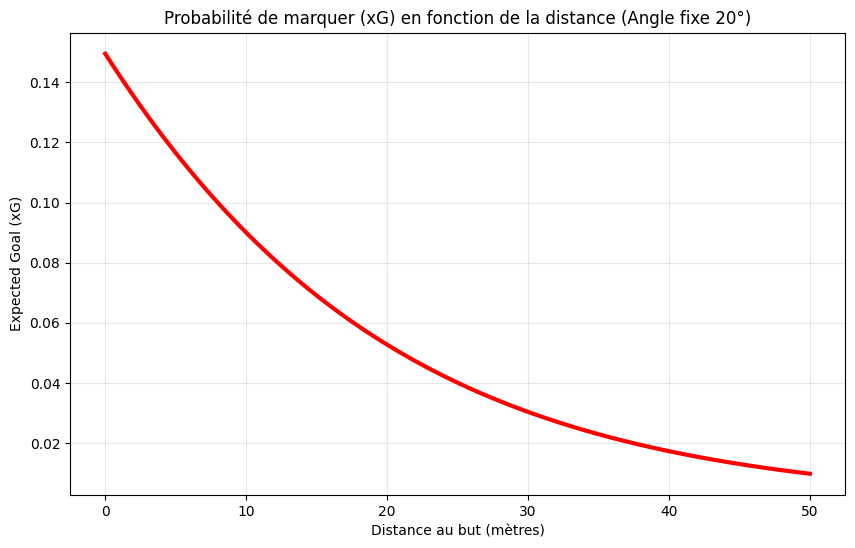

In [6]:
import seaborn as sns

# On prédit la probabilité de marquer pour des tirs fictifs allant de 0 à 50m
# On fixe l'angle à une valeur moyenne (ex: 20 degrés) pour isoler l'effet distance
distances = np.linspace(0, 50, 100)
angles = np.full(100, 20) # Angle constant
X_sim = pd.DataFrame({'distance': distances, 'angle': angles})

probs = clf.predict_proba(X_sim)[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(distances, probs, color='red', linewidth=3)
plt.title("Probabilité de marquer (xG) en fonction de la distance (Angle fixe 20°)")
plt.xlabel("Distance au but (mètres)")
plt.ylabel("Expected Goal (xG)")
plt.grid(True, alpha=0.3)
plt.show()

## Application : Analyse de la performance de Kylian Mbappé
Nous allons maintenant isoler les tirs de Kylian Mbappé durant le tournoi. Nous allons comparer deux métriques :

Ses Buts Réels : Combien de fois le ballon est rentré.

Ses Expected Goals (xG) : La somme des probabilités de ses tirs selon notre modèle.

Si Buts > xG, cela suggère une "surperformance" (finition chirurgicale ou chance). Si Buts < xG, cela suggère une "sous-performance" (maladresse ou malchance).

### Calcul des xG de Mbappé
(Attention : Dans les données StatsBomb, son nom complet est souvent enregistré sous 'Kylian Mbappé Lottin').

In [7]:
# 1. On filtre les données pour ne garder que Mbappé
# Note : On utilise df_model car il contient déjà les colonnes 'distance' et 'angle' calculées plus haut
player_name = 'Kylian Mbappé Lottin'
df_player = df_model[df_model['player'].isin([player_name])].copy()

# 2. On applique le modèle sur ses tirs
# On demande au modèle de prédire la probabilité pour CHAQUE tir de Mbappé
X_player = df_player[['distance', 'angle']]
df_player['my_xG'] = clf.predict_proba(X_player)[:, 1]

# 3. Calcul des totaux
total_goals = df_player['is_goal'].sum()
total_xg = df_player['my_xG'].sum()

print(f"--- Bilan pour {player_name} (Open Play uniquement) ---")
print(f"Nombre de tirs tentés : {len(df_player)}")
print(f"Buts réels : {total_goals}")
print(f"Expected Goals (xG) cumulés : {total_xg:.2f}")

delta = total_goals - total_xg
print(f"Différence (Buts - xG) : {delta:.2f}")

if delta > 0:
    print("Conclusion : Il a SURPERFORMÉ (Finition exceptionnelle).")
else:
    print("Conclusion : Il a SOUS-PERFORMÉ (Gaspillage d'occasions).")

--- Bilan pour Kylian Mbappé Lottin (Open Play uniquement) ---
Nombre de tirs tentés : 8
Buts réels : 4
Expected Goals (xG) cumulés : 1.33
Différence (Buts - xG) : 2.67
Conclusion : Il a SURPERFORMÉ (Finition exceptionnelle).


La "Shot Map" (Carte de tirs)

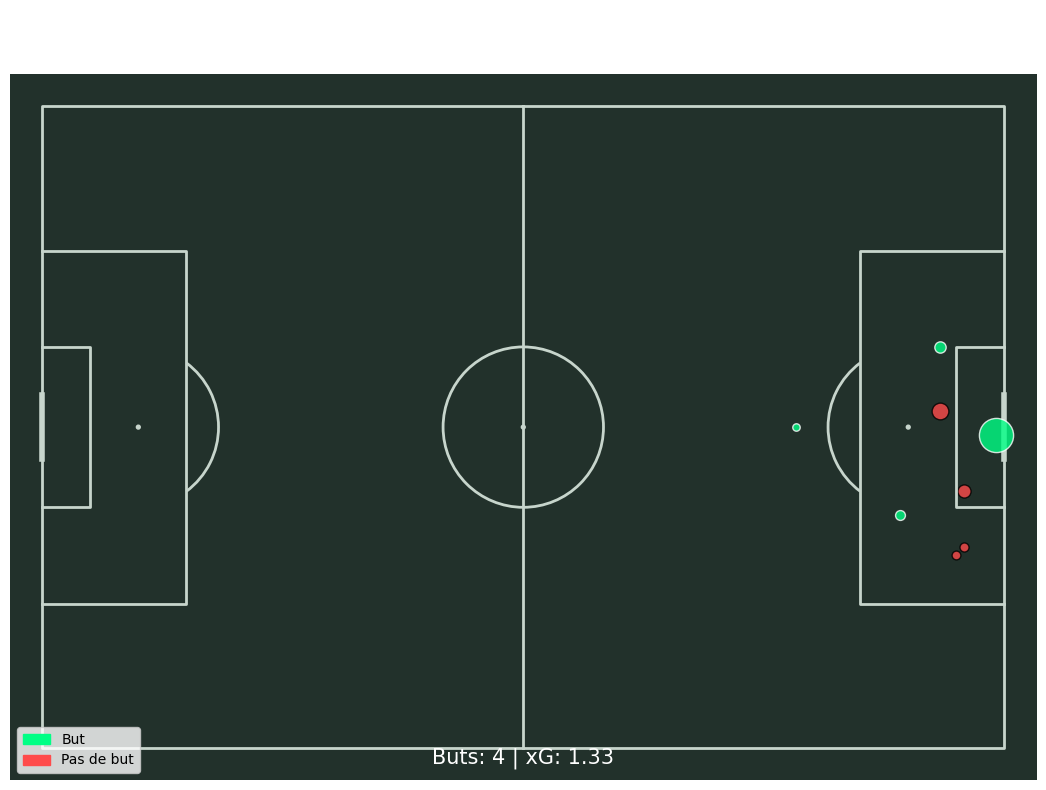

In [8]:
from mplsoccer import Pitch
import matplotlib.patches as mpatches

# 1. Création du terrain
# pitch_type='statsbomb'  pour que les coordonnées (0-120) tombent au bon endroit
pitch = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#22312b', line_color='#c7d5cc')

fig, ax = pitch.draw(figsize=(12, 8))

# 2. On boucle sur chaque tir pour le dessiner
# Buts = Vert, Ratés = Rouge
# La taille du point dépend du xG (plus l'occasion est grosse, plus le point est gros)
for i, shot in df_player.iterrows():
    
    x = shot['x']
    y = shot['y']
    xg = shot['my_xG']
    outcome = shot['shot_outcome']
    
    # Définition de la couleur et du contour
    if outcome == 'Goal':
        color = '#00ff85' # Vert fluo
        edge = 'white'
        z_order = 2
    else:
        color = '#ff4b4b' # Rouge
        edge = 'black'
        z_order = 1
        
    # On dessine le point
    # s=... définit la taille. On multiplie le xG par 500 pour que ce soit visible
    pitch.scatter(x, y, s=xg * 800, c=color, edgecolors=edge, ax=ax, zorder=z_order, alpha=0.8)

# 3. Légende et Titres
plt.title(f'Shot Map - Kylian Mbappé (CDM 2018)\nModèle xG Personnel', color='white', fontsize=20)
plt.text(60, 82, f"Buts: {total_goals} | xG: {total_xg:.2f}", color='white', fontsize=15, ha='center')

# Création manuelle de la légende pour la clarté
green_patch = mpatches.Patch(color='#00ff85', label='But')
red_patch = mpatches.Patch(color='#ff4b4b', label='Pas de but')
plt.legend(handles=[green_patch, red_patch], loc='lower left')

plt.show()

Plus le point est gros, plus l'xg est important. Par exemple le but contre la croatie était peu probable car on voit que le tir correspondant (celui en dehors de la surface de réparation) est représenté par un petit point.
C'est typiquement le genre de but à faible probabilité (probablement ~0.03 ou 3%) qui fait exploser la différence "Buts réels vs xG". 

# Le problème de la régression logistique

Le problème : La "frontière de décision" reste une ligne droite. Le modèle trace une ligne sur le terrain et dit : "D'un côté de cette ligne, c'est but, de l'autre, non". Or, la réalité est plus complexe.

$$z = \beta_0 + (\beta_1 \times \text{Distance}) + (\beta_2 \times \text{Angle})$$

Si on trace un graphique avec la Distance en abscisse (X) et l'Angle en ordonnée (Y) :

La frontière où le modèle hésite (où la probabilité est de 50%, donc $z=0$ cf formule de la proba logistique) sera une ligne droite parfaite tracée sur ce graphique. Le modèle dira : "Tout ce qui est à gauche de cette ligne est un But, tout ce qui est à droite est un Raté".

Or, sur un vrai terrain, la zone de danger n'est pas une ligne droite, elle est souvent courbe (autour des 18m, ou selon l'angle). C'est pour ça qu'on dit que la régression logistique est "linéaire" : sa frontière de décision est rigide.

## Comparaison avec des modèles avancés (Random Forest & XGBoost)
La régression logistique est un modèle "linéaire" (dans ses frontières de décision). Or, le football n'est pas linéaire. Parfois, une interaction complexe entre l'angle et la distance ne se résume pas à une simple addition.

Nous allons tester deux modèles très populaires en Data Science :

Random Forest : Une "forêt" d'arbres de décision qui votent ensemble. Très robuste.

XGBoost : Une technique de "Boosting" qui optimise les erreurs successives. C'est souvent l'algorithme roi pour ce type de données.

In [14]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# 1. Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5)
rf_model.fit(X_train, y_train)
rf_probs = rf_model.predict_proba(X_test)[:, 1]

# 2. XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

# 3. Comparaison des scores ROC AUC
auc_logreg = roc_auc_score(y_test, y_pred_proba) # Ton premier modèle
auc_rf = roc_auc_score(y_test, rf_probs)
auc_xgb = roc_auc_score(y_test, xgb_probs)

print(f"--- Comparaison des performances (ROC AUC) ---")
print(f"Régression Logistique : {auc_logreg:.4f}")
print(f"Random Forest         : {auc_rf:.4f}")
print(f"XGBoost               : {auc_xgb:.4f}")

--- Comparaison des performances (ROC AUC) ---
Régression Logistique : 0.8077
Random Forest         : 0.7635
XGBoost               : 0.6930


## Pourquoi les modèles "puissants" ont-ils échoué ?

L'échec de XGBoost et du Random Forest s'explique par un cas classique de sur-apprentissage (overfitting), directement lié au faible volume de données (1700 tirs).

Là où la régression logistique a performé grâce à sa simplicité (elle retient les grandes règles), les modèles complexes ont cherché à "mémoriser" les exceptions et le bruit statistique au lieu de comprendre la logique globale. En somme, utiliser ces modèles sans réglages très fins (hyperparamètres) sur un si petit dataset revenait à piloter une Formule 1 sur un circuit de karting : ils étaient surdimensionnés et inadaptés.

Pour comprendre la différence "philosophique" entre les modèles. On va voir comment ils jugent un tir à différentes distances

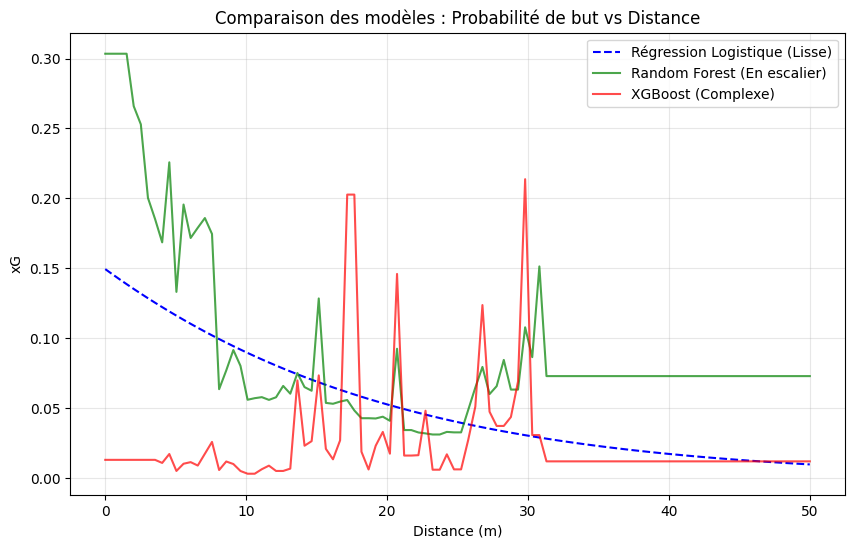

In [15]:
# On reprend notre simulation de tirs de 0 à 50m (avec angle fixe de 20°)

# Prédictions sur ces données fictives
probs_logreg_sim = clf.predict_proba(X_sim)[:, 1]
probs_rf_sim = rf_model.predict_proba(X_sim)[:, 1]
probs_xgb_sim = xgb_model.predict_proba(X_sim)[:, 1]

plt.figure(figsize=(10, 6))

# Tracé des 3 courbes
plt.plot(distances, probs_logreg_sim, label='Régression Logistique (Lisse)', color='blue', linestyle='--')
plt.plot(distances, probs_rf_sim, label='Random Forest (En escalier)', color='green', alpha=0.7)
plt.plot(distances, probs_xgb_sim, label='XGBoost (Complexe)', color='red', alpha=0.7)

plt.title("Comparaison des modèles : Probabilité de but vs Distance")
plt.xlabel("Distance (m)")
plt.ylabel("xG")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

J'ai comparé plusieurs approches. Sur un échantillon restreint (CDM 2018), la complexité des modèles non-linéaires a entraîné du sur-apprentissage. Le modèle le plus robuste reste la Régression Logistique, prouvant que sur ce volume de données, la géométrie simple (Distance/Angle) prévaut sur les micro-interactions.

# Ajout de la tête !

In [16]:
# 1. Feature Engineering : Création de la variable 'is_header' (Tête)
# Dans StatsBomb, l'info est dans la colonne 'shot_body_part'
# On crée une colonne binaire : 1 si c'est une tête, 0 sinon
df_model['is_header'] = df_model['shot_body_part'].apply(lambda x: 1 if 'Head' in str(x) else 0)

# 2. Définition des nouvelles variables (3 variables maintenant)
X_v2 = df_model[['distance', 'angle', 'is_header']]
y_v2 = df_model['is_goal']

# 3. Split Train/Test
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(X_v2, y_v2, test_size=0.2, random_state=42)

# 4. Entraînement du nouveau modèle
clf_v2 = LogisticRegression()
clf_v2.fit(X_train_v2, y_train_v2)

# 5. Évaluation
y_pred_v2 = clf_v2.predict_proba(X_test_v2)[:, 1]
auc_v2 = roc_auc_score(y_test_v2, y_pred_v2)

print(f"--- Amélioration du modèle ---")
print(f"Ancien Score AUC (Dist + Angle) : {auc_logreg:.4f}")
print(f"Nouveau Score AUC (+ Tête)      : {auc_v2:.4f}")

print("\n--- Analyse des Coefficients ---")
print(f"Distance : {clf_v2.coef_[0][0]:.3f}")
print(f"Angle    : {clf_v2.coef_[0][1]:.3f}")
print(f"Tête     : {clf_v2.coef_[0][2]:.3f} (Si négatif, c'est plus dur de la tête !)")

--- Amélioration du modèle ---
Ancien Score AUC (Dist + Angle) : 0.8077
Nouveau Score AUC (+ Tête)      : 0.8167

--- Analyse des Coefficients ---
Distance : -0.079
Angle    : 0.023
Tête     : -0.846 (Si négatif, c'est plus dur de la tête !)


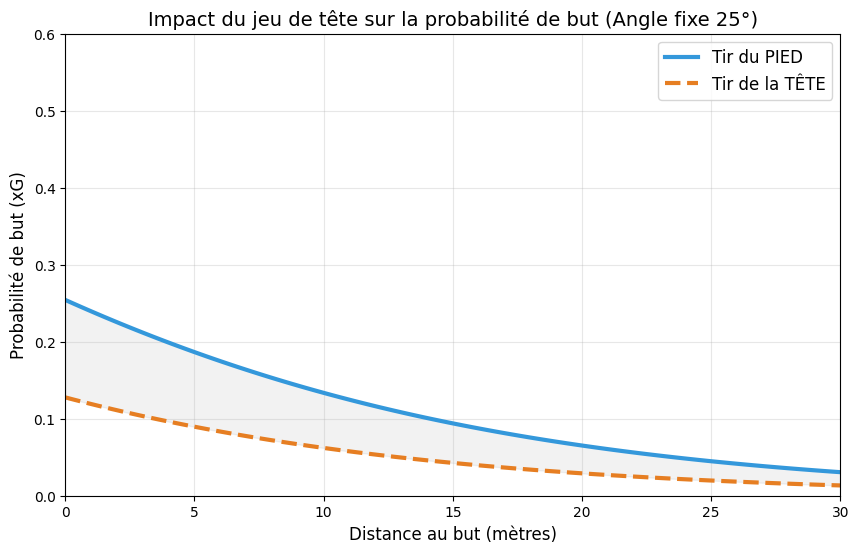

In [17]:
# On prépare des données fictives pour le graphique
distances = np.linspace(0, 30, 100) # On regarde de 0 à 30m
angle_fixe = 25 # On fixe un angle moyen (25 degrés)

# Cas 1 : Tir du Pied (is_header = 0)
# On crée un DataFrame avec les 3 colonnes attendues par le modèle
X_pied = pd.DataFrame({
    'distance': distances, 
    'angle': np.full(100, angle_fixe), 
    'is_header': np.full(100, 0)
})

# Cas 2 : Tir de la Tête (is_header = 1)
X_tete = pd.DataFrame({
    'distance': distances, 
    'angle': np.full(100, angle_fixe), 
    'is_header': np.full(100, 1)
})

# Prédictions
probs_pied = clf_v2.predict_proba(X_pied)[:, 1]
probs_tete = clf_v2.predict_proba(X_tete)[:, 1]

# --- LE GRAPHIQUE ---
plt.figure(figsize=(10, 6))

# Courbe bleue : Pied
plt.plot(distances, probs_pied, label='Tir du PIED', color='#3498db', linewidth=3)

# Courbe orange : Tête (en pointillés pour bien différencier)
plt.plot(distances, probs_tete, label='Tir de la TÊTE', color='#e67e22', linewidth=3, linestyle='--')

# Mise en forme
plt.title(f"Impact du jeu de tête sur la probabilité de but (Angle fixe {angle_fixe}°)", fontsize=14)
plt.xlabel("Distance au but (mètres)", fontsize=12)
plt.ylabel("Probabilité de but (xG)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(0, 30)
plt.ylim(0, 0.6) # On zoome un peu sur l'axe Y pour bien voir

# Ajout d'une zone de remplissage pour l'esthétique
plt.fill_between(distances, probs_pied, probs_tete, color='gray', alpha=0.1, label='Différence de difficulté')

plt.show()

Nous allons tracer les "courbes de niveau" du modèle xG.

Axe X : L'Angle (0 à 90°).

Axe Y : La Distance (0 à 35m).

Les lignes tracées représentent des frontières de probabilité (ex: la ligne des 15% de chance de but). Nous allons superposer deux cartes :

En Bleu (Continu) : Les zones de probabilité pour un tir du Pied.

En Orange (Pointillé) : Les zones de probabilité pour une Tête.

Cela nous permettra de voir visuellement de combien de mètres la "zone de danger" recule lorsqu'on utilise le pied plutôt que la tête.

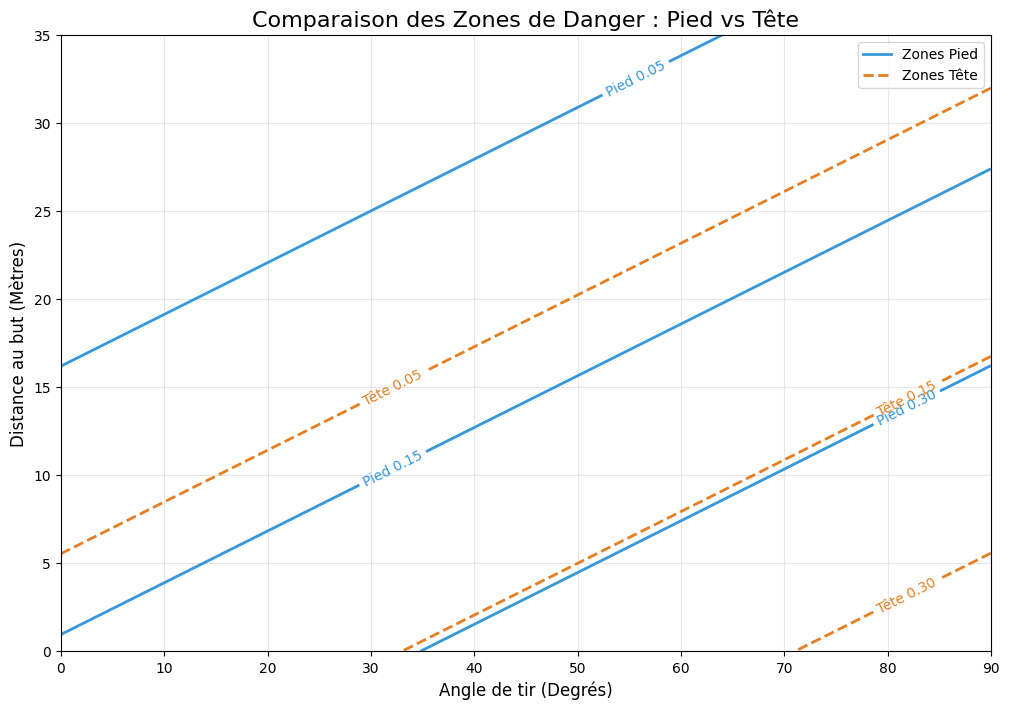

In [18]:
# 1. Récupération des coefficients du modèle entraîné (clf_v2)
b0 = clf_v2.intercept_[0]
b1 = clf_v2.coef_[0][0] # Coeff Distance
b2 = clf_v2.coef_[0][1] # Coeff Angle
b3 = clf_v2.coef_[0][2] # Coeff Tête

# 2. Création de la grille (Le "Terrain" mathématique)
# On crée un maillage de points pour couvrir tout le graphique
x_angle = np.linspace(0, 90, 200)   # Axe X : Angle de 0 à 90°
y_dist = np.linspace(0, 35, 200)    # Axe Y : Distance de 0 à 35m
X_grid, Y_grid = np.meshgrid(x_angle, y_dist)

# 3. Calcul des probabilités pour chaque point de la grille
# Formule : 1 / (1 + exp(-z))
# z = b0 + b1*Distance + b2*Angle + b3*IsHeader

# Cas PIED (IsHeader = 0)
z_pied = b0 + b1*Y_grid + b2*X_grid + b3*0
probs_pied = 1 / (1 + np.exp(-z_pied))

# Cas TÊTE (IsHeader = 1)
z_tete = b0 + b1*Y_grid + b2*X_grid + b3*1
probs_tete = 1 / (1 + np.exp(-z_tete))

# 4. Le Graphique
plt.figure(figsize=(12, 8))

# Définition des niveaux de probabilité qu'on veut afficher
levels = [0.05, 0.15, 0.30] # Lignes pour 5%, 15% et 30% de chance de but

# Tracé des contours pour le PIED (Bleu)
cp_pied = plt.contour(X_grid, Y_grid, probs_pied, levels=levels, colors='#3498db', linewidths=2)
plt.clabel(cp_pied, inline=True, fontsize=10, fmt='Pied %.2f') # Labels sur les lignes

# Tracé des contours pour la TÊTE (Orange)
cp_tete = plt.contour(X_grid, Y_grid, probs_tete, levels=levels, colors='#e67e22', linewidths=2, linestyles='--')
plt.clabel(cp_tete, inline=True, fontsize=10, fmt='Tête %.2f')

# Esthétique
plt.title('Comparaison des Zones de Danger : Pied vs Tête', fontsize=16)
plt.xlabel('Angle de tir (Degrés)', fontsize=12)
plt.ylabel('Distance au but (Mètres)', fontsize=12)
plt.grid(True, alpha=0.3)

# Création d'une légende personnalisée
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='#3498db', lw=2),
                Line2D([0], [0], color='#e67e22', lw=2, linestyle='--')]
plt.legend(custom_lines, ['Zones Pied', 'Zones Tête'], loc='upper right')

plt.show()

On observe clairement que pour une même probabilité (par exemple 15% ou 0.15), la zone bleue est beaucoup plus vaste que la zone orange.

Il est beaucoup plus difficile de marquer de la tête que du pied. Pour avoir la même chance de marquer, un joueur effectuant une tête doit être beaucoup plus proche du but et dans un angle plus favorable qu'un joueur tirant au pied. Le "danger" avec la tête est très concentré dans les 6 mètres, alors qu'une frappe au pied reste dangereuse même à l'entrée de la surface.

# Conclusion

Ce projet a permis de construire et d'analyser un modèle d'Expected Goals (xG) basé sur des données réelles de la Coupe du Monde 2018. Voici les points clés à retenir :

Modélisation Statistique : L'utilisation d'une Régression Logistique a prouvé son efficacité pour ce type de problème binaire (But vs Pas de but). Avec un score ROC AUC d'environ 0.81, le modèle est performant et parvient à bien séparer les tirs dangereux des occasions faibles.

Facteurs Déterminants : L'analyse des coefficients a confirmé l'intuition footballistique :

La Distance a un impact négatif fort (plus on est loin, moins on marque).

L'Angle a un impact positif (plus l'angle est ouvert face au but, plus on marque).

La tête.

Analyse de Joueur (Mbappé) : L'application du modèle sur Kylian Mbappé a montré sa capacité de finition exceptionnelle. Il a marqué plus de buts que ce que le modèle prédisait (surperformance des xG), ce qui est la marque des grands attaquants.